In [1]:
import os
# import sys
# sys.path.append('../../../gene_program_evaluation/gene_network_evaluation/src')
# from inference.program_models import run_consensus_NMF_, run_cnmf_factorization, run_cnmf_consensus, init_cnmf_obj

import math

import mudata
import scanpy as scp

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels.stats.multitest import fdrcorrection
from statsmodels.regression.mixed_linear_model import MixedLM

from joblib import Parallel, delayed
from tqdm.auto import tqdm

/home/users/ymo/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
def load(k, term, path):
    df = pd.read_csv(path, sep='\t')
    df = df.loc[df['Adjusted P-value']<=0.05]
    df['num_programs'] = k
    df['test_term'] = term
    return df

components = [30, 60, 80, 100, 200, 250, 300]
term_df = []

folder = "/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Results/sk-cNMF_evaluation/082525_100k_10iter_sk_mu_frobenius/Eval"

for k in components:

    term_df.append(load(k, 'go_terms', '{}/{}/{}_GO_term_enrichment.txt'.format(folder,k,k)))
    term_df.append(load(k, 'genesets', '{}/{}/{}_geneset_enrichment.txt'.format(folder,k,k)))
    term_df.append(load(k, 'traits', '{}/{}/{}_trait_enrichment.txt'.format(folder,k,k)))
    #term_df.append(load(k, 'motifs', '{}/{}_motif_enrichment.txt'.formatk,k)))   

term_df = pd.concat(term_df, ignore_index=True)

In [3]:
# Count unique terms per k
count_df = pd.DataFrame(index=components, columns=term_df['test_term'].unique())

for k in components:
    for col in count_df.columns:
        count_df.loc[k, col] = term_df.loc[(term_df['num_programs']==k) & (term_df['test_term']==col), 'Term'].unique().shape[0]

In [4]:
# Compute no. of unique regulators

test_stats_df = []
for k in [30, 60, 80, 100, 200, 250, 300]: # 400

    # Run perturbation assocation
    for samp in ['D0', 'sample_D1', 'sample_D2', 'sample_D3']:
        test_stats_df_ = pd.read_csv('{}/{}_perturbation_association_results_{}.txt'.format(k,k,samp), sep='\t')
        test_stats_df_['sample'] = samp
        test_stats_df_['K'] = k
        test_stats_df_['fdr'] = fdrcorrection(test_stats_df_['pval'])[1]
        test_stats_df.append(test_stats_df_)
test_stats_df = pd.concat(test_stats_df, ignore_index=True)

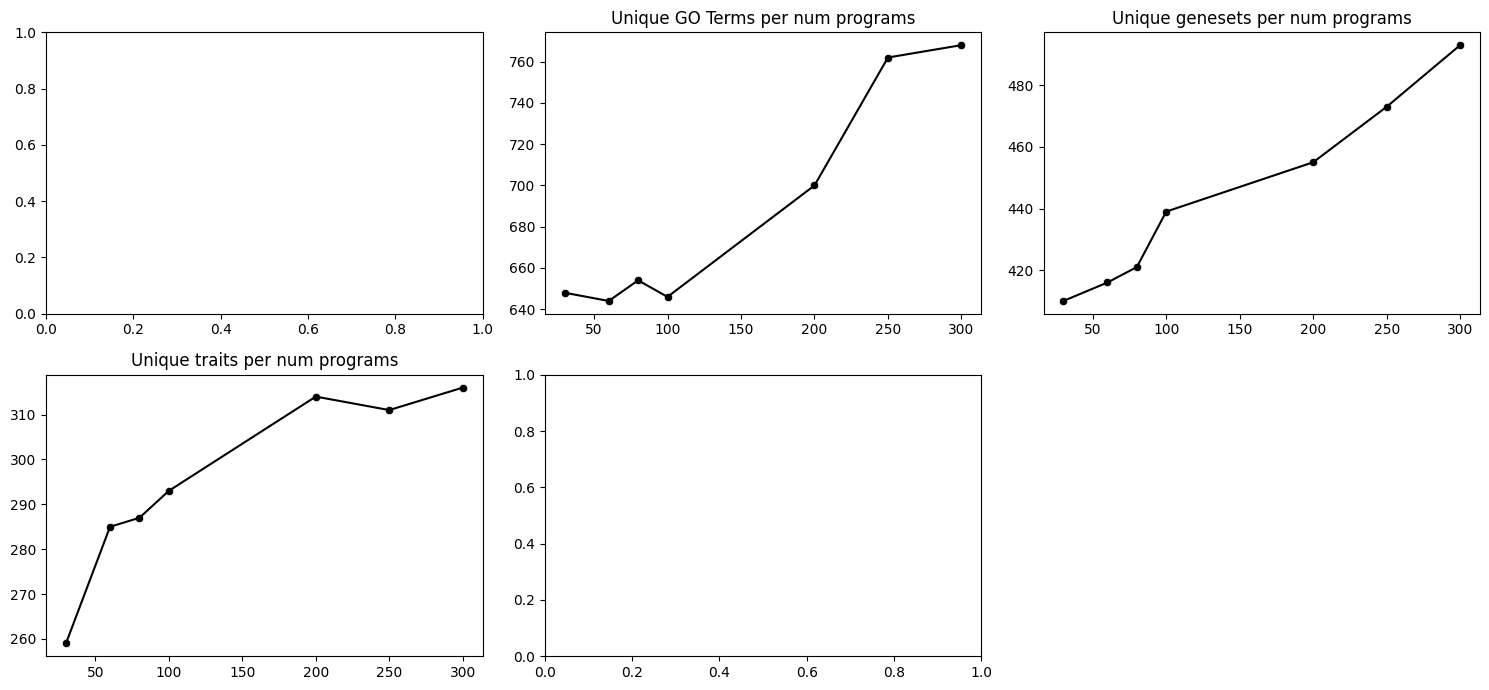

In [4]:
# Select significant K

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,7))

'''
# Explained variance
axs.flat[0].set_title('Unique regulators of progams (pval <=0.000335)')
plotting_df = test_stats_df.loc[test_stats_df.pval<=0.000335, ['K', 'sample','target_name']].drop_duplicates().groupby(['K', 'sample']).count().reset_index()
sns.lineplot(x='K', y='target_name', hue='sample', data=plotting_df, ax=axs.flat[0])

plotting_df = test_stats_df.loc[test_stats_df.pval<=0.000335, ['K','target_name']].drop_duplicates().groupby(['K']).count().reset_index()
sns.lineplot(x='K', y='target_name', data=plotting_df, color='black', ax=axs.flat[0])
'''
# Unique GO Terms
sns.scatterplot(x='index', y='go_terms', data=count_df.reset_index(), ax=axs.flat[1], color='black')
sns.lineplot(x='index', y='go_terms', data=count_df.reset_index(), ax=axs.flat[1], color='black')
axs.flat[1].set_title('Unique GO Terms per num programs')

# Unique Gene sets
sns.scatterplot(x='index', y='genesets', data=count_df.reset_index(), ax=axs.flat[2], color='black')
sns.lineplot(x='index', y='genesets', data=count_df.reset_index(), ax=axs.flat[2], color='black')
axs.flat[2].set_title('Unique genesets per num programs')

# Unique Traits
sns.scatterplot(x='index', y='traits', data=count_df.reset_index(), ax=axs.flat[3], color='black')
sns.lineplot(x='index', y='traits', data=count_df.reset_index(), ax=axs.flat[3], color='black')
axs.flat[3].set_title('Unique traits per num programs')
'''
# Unique Motifs
# sns.scatterplot(x='index', y='motifs', data=count_df.reset_index(), ax=axs.flat[5], color='black')
# sns.lineplot(x='index', y='motifs', data=count_df.reset_index(), ax=axs.flat[5], color='black')
axs.flat[4].set_title('Unique motifs per num programs')

'''
for ax in axs.flat[:]:
    ax.set_xlabel('')
    ax.set_ylabel('')
axs.flat[-1].axis('off')

plt.tight_layout()
plt.savefig(f'{folder}/cNMF_k_selection_evaluations.png', dpi=100)
